<a href="https://colab.research.google.com/github/arpitvaghela/DSA_FL/blob/main/DSA_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSA_24

In [ ]:
import numpy as np
import math
from scipy.stats import norm
import time
import pandas as pd
import statsmodels.api as sm
import pickle
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

## Retriving data

In [ ]:
## Importing data from file (96.7 MHz)
FM = np.fromfile('96_7_20db', dtype=np.float32)

# Reshaping to convert to a proper NUMPY vector
FM = np.reshape(FM, (FM.shape[0], 1))

# Shape of FM signal vector
print("Size of FM: " + str(FM.shape))

Size of FM: (2971649, 1)


### Bandpower Equation


In [ ]:
def bandpower(signal:np.array)->np.float:
  return np.mean(signal ** 2)

In [ ]:
bandpower(FM)

0.08850595

### awgn Function

Function to add noise to the signal resulting in given S/N ratio

In [ ]:
def awgn(signal:np.ndarray, desired_snr:int):
  """Add AWGN noise to generate signal with given SNR. 
  """
  # Converting the SNR from dB scale to linear scale
  snr_linear = math.pow(10, desired_snr / 10)
  
  # Standard normally distributed noise
  noise = np.random.randn(signal.shape[0], 1)
  
  # Using the boxed formula
  var_signal = bandpower(noise) * snr_linear
  
  # Normalizing the signal to have the given variance
  normalized_signal = math.sqrt(var_signal) * (signal / math.sqrt(bandpower(signal)))
  
  print("SNR = " + str(10 * math.log10(bandpower(normalized_signal) / bandpower(noise))))
  
  return normalized_signal + noise

## Filtering Data

filtering data points to be in range $10^{-7}< signal< 1$

In [ ]:
FM = FM[np.logical_and(FM > math.pow(10, -7), FM < 1)]
FM = FM.reshape(FM.shape[0], 1)
print("Size of FM: " + str(FM.shape))

Size of FM: (2971649, 1)


## Creating Dataset

- take datapoints of size, _samples*sample_size_

- add noise with desire snr

- sample = $[s_1,s_2,\cdots,s_N]$

- Energy detection = $\sum_{i=1}^{N}s_i^2$

- $X[j]$ = $\sum_{i=j*N+1}^{(j+1)*N}s_i^2$

In [ ]:
def create_dataset(signal, desired_snr, samples, sample_size):
  
  # Creating the signal with desired SNR
  snr_signal = awgn(signal[0:samples * sample_size], desired_snr)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 1))
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = snr_signal[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
  
  return X

In [ ]:
%%time
# sample dataset for SNR=4

print(create_dataset(FM[50000:], 4, 15000, 100).shape)

SNR = 4.000000136584121
(15000, 1)
CPU times: user 294 ms, sys: 0 ns, total: 294 ms
Wall time: 294 ms


In [ ]:
def final_dataset(signal, snr_range, samples_per_snr, sample_size):
  X = {}
  
  for snr in snr_range:
    # Creating dataset for the given SNR
    X_snr = create_dataset(signal, snr, samples_per_snr, sample_size)
    
    # Indexing within the final dataset matrix X
    X[snr] = X_snr
  
  return X

## Generating White Noise Sequence 

In [ ]:
def create_noise_sequence(samples, sample_size):
  
  # Creating white noise sequence of variance 1
  noise = np.random.randn(samples * sample_size, 1)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 1))
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = noise[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
  
  return X

## DataSet LookBack for RNN

In [ ]:
# Function for Chaning the dataset for look back  #linear dataset initially
def create_look_back(X, look_back=1):
  
  # Look back dataset is initialized to be empty
  look_back_X = []
  
  for i in range(len(X) - look_back + 1):
    # Extracting an example from the dataset
    a = X[i:(i + look_back), :]
    
    a = a.flatten() # (For flattening) #1D list
    
    # Appending to the dataset
    look_back_X.append(a)
  
#  look_back_Y = []
    
  # Returning in numpy's array format
  return np.array(look_back_X)

In [ ]:
def dataset_look_back(X_tech, snr_range, look_back):
  X_tech_lb = {}
  
  # Look backs for all SNRs
  for snr in snr_range:
    X_tech_lb[snr] = create_look_back(X_tech[snr], look_back)
  
  return X_tech_lb

In [ ]:
def generate_Dataset(FM,snr_ratio=(0.8, 0.2),sample_size=100,total_sample=100000,lsnr_range=(-20,-4),hsnr_range=(-4,6),look_back = 2,eval=False):

  no_of_sample_hsnr = int((total_sample*snr_ratio[0])//((hsnr_range[1] - hsnr_range[0])/2))
  no_of_sample_lsnr = int((total_sample*snr_ratio[1])//((lsnr_range[1] - lsnr_range[0])/2))
  
  X_FM = {**final_dataset(FM[100000:], range(lsnr_range[0],lsnr_range[1], 2),no_of_sample_lsnr, sample_size),
          **final_dataset(FM[100000:], range(hsnr_range[0],hsnr_range[1], 2), no_of_sample_hsnr, sample_size)}

  X_noise = create_noise_sequence(100000, 100)

  # lookback

  X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), look_back)
  X_noise_lb = create_look_back(X_noise, look_back)

  # final X_train and y

  X = X_FM_lb[-20]
  y = []

  for snr in range(-18, 6, 2):
    X = np.concatenate((X, X_FM_lb[snr]), axis=0)

  y = np.ones((X.shape[0], 1))
 
  # print(X.shape)
  # print(X_noise_lb.shape)
  X = np.concatenate((X, X_noise_lb), axis=0)
  y_train = np.concatenate((y, np.zeros((X_noise_lb.shape[0], 1))))

  # reshape
  X_train = np.reshape(X, (X.shape[0], X.shape[1], 1))

  # Pd plot for various SNR
  X_eval = X_FM_lb
  X_noise_eval = X_noise_lb
  if eval:
    return X_train,y_train,X_eval,X_noise_eval

  return X_train,y_train

 

## Final Model

In [ ]:
model_inuse = Sequential([
      LSTM(4,input_dim=1),
      Dense(1, kernel_initializer="uniform", activation="sigmoid"),
  ])

model_inuse.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
ratio_inuse = (0.6,0.4)

X,y= generate_Dataset(FM[100000:],snr_ratio=ratio_inuse)

model_inuse.fit(X,y,epochs=10,verbose=1)
model_inuse.summary()


SNR = -20.000001934939768
SNR = -18.00000036586637
SNR = -16.000000972089993
SNR = -13.999999952699788
SNR = -12.000000646640377
SNR = -10.000000242437995
SNR = -7.999998841834374
SNR = -6.000000978405097
SNR = -4.000001127644202
SNR = -2.000001038083761
SNR = -1.4723522043289024e-06
SNR = 1.9999988384042808
SNR = 3.999999540566134
Epoch 1/10
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2500 - accuracy: 0.5008
Epoch 2/10
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2500 - accuracy: 0.5001
Epoch 3/10
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2500 - accuracy: 0.5013
Epoch 4/10
6250/6250 [==============================] - 18s 3ms/step - loss: 0.2500 - accuracy: 0.4986
Epoch 5/10
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2500 - accuracy: 0.4989
Epoch 6/10
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2500 - accuracy: 0.4998
Epoch 7/10
6250/6250 [==========================

In [ ]:
model_inuse.predict([
                     [[200],[150]],
                     [[107],[107]],
                     [[-100],[-100]],
                     [[100],[101]]
                     ])

In [ ]:
!rm -r /content/model
model_inuse.save('/content/model')

In [ ]:
!zip /content/model_v2.zip -r /content/model

In [ ]:
reconst_model = tf.keras.models.load_model("/content/model")

reconst_model.predict([
                     [[200],[150]],
                     [[107],[107]],
                     [[-100],[-100]],
                     [[100],[101]]
                     ])

# Plot of 90-10 80-20 70-30 ... models
*high to low SNR datapoints*

In [ ]:
# Pd at snr for various model 90-10, 80-20 .....

def generate_plot_for_snr_ratio():
  model_final = Sequential([
      LSTM(4, input_dim=1, return_sequences=True),
      Dense(1, kernel_initializer="uniform", activation="sigmoid"),
  ])
  model_final.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model_final.summary()

  pd_FM = {}
  ratios = [(0.9,0.1),(0.8,0.2),(0.6,0.4),(0.4,0.6),(0.3,0.7),(0.2,0.8),(0.1,0.9)]
  markers = ['o','.','v','8','*','D','^']
  pf = []
  for i,ratio in enumerate(ratios):
    print("\nSNR ratio: ",ratio[0]*100,"-",ratio[1]*100)

    X_train,y,X_FM_lb,X_noise_eval= generate_Dataset(FM[100000:],snr_ratio=ratio,eval=True)
    model_final.fit(X_train, y, epochs=5,  verbose=1)

    # False Alarm probability
    y_noise = np.zeros((X_noise_eval.shape[0], 1))
    x_noise = np.reshape(X_noise_eval, (X_noise_eval.shape[0], X_noise_eval.shape[1], 1))
    Pf_score = model_final.evaluate(x_noise,y_noise)
    print("Pf (Probability of False detection): %.2f%%" % ((1- Pf_score[1])*100))
    pf.append(Pf_score)
    # Detection Probability
    for snr in range(-20, 6, 2):
      y_snr = np.ones((X_FM_lb[snr].shape[0], 1))
      x_snr = np.reshape(X_FM_lb[snr], (X_FM_lb[snr].shape[0], X_FM_lb[snr].shape[1], 1))
      scores = model_final.evaluate(x_snr, y_snr)
      print("At SNR = " + str(snr) + "\n%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))
      pd_FM[snr] = scores[1]

    plt.plot(
        range(-20, 6, 2),
         list(pd_FM.values()),
         marker=markers[i],
         label=str(ratio[0]*100)+"-"+str(ratio[1]*100)
         )

  plt.xlabel("SNR")
  plt.ylabel("Probability of detection")
  plt.legend()
  plt.savefig("Figure1.png")
  plt.show()

# Pf table

  print("\t\t Pf")
  for i,ratio in enumerate(ratios):
    print("Model %s-%s:\t %.2f" % (str(int(ratio[0]*100)),str(int(ratio[1]*100)),(1 - pf[i][1])) ) 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 4)           96        
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________

SNR ratio:  90.0 - 10.0
SNR = -20.000000850901234
SNR = -18.000001591532587
SNR = -16.000001381801503
SNR = -14.000001103949158
SNR = -12.000001368758111
SNR = -10.000000404766489
SNR = -8.000000408684667
SNR = -6.000001277274656
SNR = -4.000001888390266
SNR = -1.999998873209052
SNR = -2.4206420475789427e-06
SNR = 1.9999989574558243
SNR = 3.9999964311777996
Epoch 1/5
6250/6250 [==============================] - 23s 4ms/step - loss: 0.2467 - accuracy: 0.5740
Epoch 2/5
6250/6250 [==============================] - 

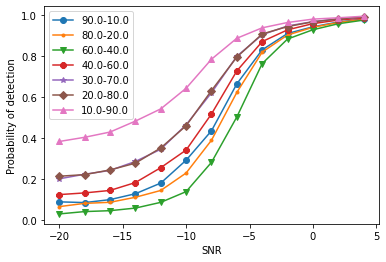

		 Pf
Model 90-10:	 0.07
Model 80-20:	 0.05
Model 60-40:	 0.03
Model 40-60:	 0.11
Model 30-70:	 0.18
Model 20-80:	 0.18
Model 10-90:	 0.35


In [ ]:
pf = generate_plot_for_snr_ratio()

# Plot for various Sample Size 

In [ ]:
def generate_plot_for_samplesize():
  model_final = Sequential([
      LSTM(4, input_dim=1, return_sequences=True),
      Dense(1, kernel_initializer="uniform", activation="sigmoid"),
  ])
  model_final.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model_final.summary()

  pd_FM = {}
  sample_sizes = [10,50,100,150,250]
  markers = ['*','^','8','s','D']
  pf = []
  for i,N in enumerate(sample_sizes):
    print("\nSample Size: ",N)

    X_train,y,X_FM_lb,X_noise_eval= generate_Dataset(FM[100000:],sample_size=N,eval=True)
    model_final.fit(X_train, y, epochs=5,  verbose=1)

    # False Alarm probability
    y_noise = np.zeros((X_noise_eval.shape[0], 1))
    x_noise = np.reshape(X_noise_eval, (X_noise_eval.shape[0], X_noise_eval.shape[1], 1))
    Pf_score = model_final.evaluate(x_noise,y_noise)
    print("Pf (Probability of False detection): %.2f%%" % ((1- Pf_score[1])*100))
    pf.append(Pf_score)
    # Detection Probability
    for snr in range(-20, 6, 2):
      y_snr = np.ones((X_FM_lb[snr].shape[0], 1))
      x_snr = np.reshape(X_FM_lb[snr], (X_FM_lb[snr].shape[0], X_FM_lb[snr].shape[1], 1))
      scores = model_final.evaluate(x_snr, y_snr)
      print("At SNR = " + str(snr) + "\n%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))
      pd_FM[snr] = scores[1]

    plt.plot(
        range(-20, 6, 2),
         list(pd_FM.values()),
         marker=markers[i],
         label="Sample size("+str(N)+")"
         )

  plt.title("P_d at various Sample size")
  plt.xlabel("SNR")
  plt.ylabel("Probability of detection")
  plt.legend()
  plt.savefig("Figure1.png")
  plt.show()

  print("\t\t Pf")
  for i,N in enumerate(sample_sizes):
    print("Sample size(%s) :\t %.2f" % (str(N),(1 - pf[i][1])) ) 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 4)           96        
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________

Sample Size:  10
SNR = -19.999999325878946
SNR = -17.999999924167135
SNR = -15.999999459671441
SNR = -13.999999417427658
SNR = -11.999999439279463
SNR = -9.99999969367983
SNR = -8.00000018855709
SNR = -5.999999281967576
SNR = -4.00000026852802
SNR = -2.000000428575227
SNR = 8.403138565349052e-08
SNR = 1.9999993253903512
SNR = 3.999999397266394
Epoch 1/5
6250/6250 [==============================] - 22s 4ms/step - loss: 0.0426 - accuracy: 0.9805
Epoch 2/5
6250/6250 [==============================] - 22s 4ms/step -

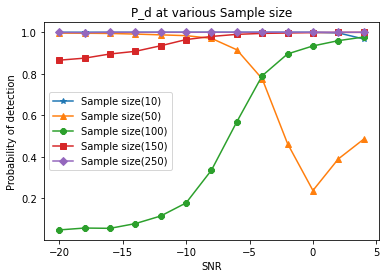

		 Pf
Sample size(10) :	 0.00
Sample size(50) :	 0.04
Sample size(100) :	 0.04
Sample size(150) :	 0.00
Sample size(250) :	 0.00


In [ ]:
generate_plot_for_samplesize()

#

In [ ]:
X_train,y= generate_Dataset(FM[100000:])

SNR = -19.999999499215182
SNR = -17.99999998125356
SNR = -16.000000411036122
SNR = -13.999999626530313
SNR = -11.999999193227513
SNR = -9.999999586170816
SNR = -8.000000193018582
SNR = -5.999999998543524
SNR = -4.0000002454950465
SNR = -2.0000008524504045
SNR = -2.0865273517845427e-06
SNR = 1.9999987040519243
SNR = 3.9999993560759495


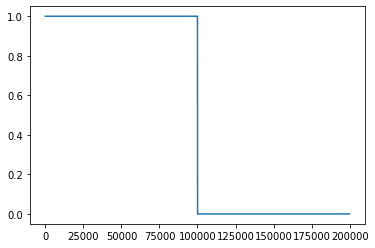

In [ ]:
plt.plot(y)

(199986, 2, 1)

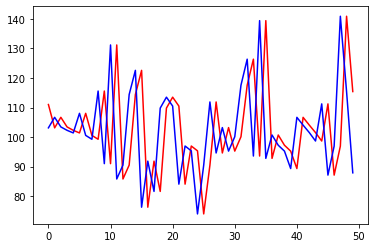

In [ ]:
plt.plot(X_train[100:150,0],'r-')
plt.plot(X_train[100:150,1],'b-')
X_train.shape

In [ ]:
#X_train = np.reshape(X, (X.shape[0], X.shape[1], 1))
#X_train

# Plots with different LSTM layers

In [ ]:
from tensorflow.keras.layers import Flatten, Conv1D

In [ ]:
%%time
seed = 9
np.random.seed(seed)
# Loading the data, here It's a feature data, which contains 4 features as mentioned in papers 

model1 = Sequential([
    LSTM(200, input_dim=1, return_sequences=True),
    Dense(1, kernel_initializer="uniform", activation="sigmoid"),
])

model128 = Sequential([
    LSTM(200, input_dim=1, return_sequences=True),
    Dropout(0.2),
    Dense(128, kernel_initializer="uniform", activation="relu"),
    Dense(1, kernel_initializer="uniform", activation="sigmoid"),
])

model256 = Sequential([
    LSTM(400, input_dim=1, return_sequences=True),
    Dropout(0.2),
    Dense(256, kernel_initializer="uniform", activation="relu"),
    Dense(1, kernel_initializer="uniform", activation="sigmoid"),
])

# Compile model
# This function you have to explore in case you want to do the mathematic analysis
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model128.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model256.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


d = {}

for i in [5, 10, 15]:
    hist1 = model1.fit(X_train, y, epochs=i,  verbose=1, validation_split=0.1)
    hist2 = model128.fit(X_train, y, epochs=i,  verbose=1, validation_split=0.1)
    hist3 = model256.fit(X_train, y, epochs=i,  verbose=1, validation_split=0.1)

    d[str(i) + "-hist1"] = hist1.history
    d[str(i) + "-hist128"] = hist2.history
    d[str(i) + "-hist256"] = hist3.history

pickle.dump(d, open("80-20.pkl", "wb"))

Epoch 1/5
5625/5625 [==============================] - 22s 4ms/step - loss: 0.3496 - accuracy: 0.8437 - val_loss: 0.2797 - val_accuracy: 0.9342
Epoch 2/5
5625/5625 [==============================] - 21s 4ms/step - loss: 0.3409 - accuracy: 0.8469 - val_loss: 0.3773 - val_accuracy: 0.8795
Epoch 3/5
5625/5625 [==============================] - 22s 4ms/step - loss: 0.3395 - accuracy: 0.8473 - val_loss: 0.2671 - val_accuracy: 0.9535
Epoch 4/5
5625/5625 [==============================] - 21s 4ms/step - loss: 0.3385 - accuracy: 0.8479 - val_loss: 0.3072 - val_accuracy: 0.9255
Epoch 5/5
5625/5625 [==============================] - 21s 4ms/step - loss: 0.3378 - accuracy: 0.8484 - val_loss: 0.2581 - val_accuracy: 0.9553
Epoch 1/5
5625/5625 [==============================] - 25s 4ms/step - loss: 0.3395 - accuracy: 0.8466 - val_loss: 0.3234 - val_accuracy: 0.9505
Epoch 2/5
5625/5625 [==============================] - 24s 4ms/step - loss: 0.3354 - accuracy: 0.8484 - val_loss: 0.3242 - val_accuracy:

In [ ]:
from pprint import pprint
pprint(d)

{'10-hist1': {'accuracy': [0.8483973741531372,
                           0.8486613035202026,
                           0.8492252230644226,
                           0.8490057587623596,
                           0.8497002720832825,
                           0.8501613736152649,
                           0.850355863571167,
                           0.8507447838783264,
                           0.8505975604057312,
                           0.8511142730712891],
              'loss': [0.33762240409851074,
                       0.3366241455078125,
                       0.33575472235679626,
                       0.3351942300796509,
                       0.33459600806236267,
                       0.3341529071331024,
                       0.3331027626991272,
                       0.33256903290748596,
                       0.332501620054245,
                       0.33140572905540466],
              'val_accuracy': [0.8996449708938599,
                               0.94849741458

In [ ]:
#model.save("drive/My Drive/wc")
# model.save("wc.h5")

In [ ]:
# MODEL 128 hidden 
model = Sequential() # This means it's sequential model, which is from one direction to another in sequence 
model.add(LSTM(4,input_dim=1)) # 4 layers of lstm
model.add(Dense(128,kernel_initializer='uniform', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid')) #Output layer

# Compile model
#This function you have to explore in case you want to do the mathematic analysis
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train,y,epochs=5,verbose=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dense_13 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
6250/6250 [==============================] - 19s 3ms/step - loss: 0.6943 - accuracy: 0.5009
Epoch 2/5
6250/6250 [==============================] - 19s 3ms/step - loss: 0.6942 - accuracy: 0.4994
Epoch 3/5
6250/6250 [==============================] - 19s 3ms/step - loss: 0.6938 - accuracy: 0.4999
Epoch 4/5
6250/6250 [==============================] - 19s 3ms/step - loss: 0.6

In [ ]:
model = Sequential() # This means it's sequential model, which is from one direction to another in sequence 
model.add(LSTM(4,input_dim=1)) # 4 layers of lstm
model.add(Dense(256,kernel_initializer='uniform', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid')) #Output layer

# Compile model
#This function you have to explore in case you want to do the mathematic analysis
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train,y,epochs=5,verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dense_15 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
6250/6250 [==============================] - 21s 3ms/step - loss: 0.3525 - accuracy: 0.8523
Epoch 2/5
6250/6250 [==============================] - 19s 3ms/step - loss: 0.3126 - accuracy: 0.8714
Epoch 3/5
6250/6250 [==============================] - 19s 3ms/step - loss: 0.3108 - accuracy: 0.8722
Epoch 4/5
6250/6250 [==============================] - 19s 3ms/step - loss: